In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST


In [3]:
# Define a lightweight CNN architecture
class LightweightCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(LightweightCNN, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 3 * 3, 128)  # 28x28 -> 14x14 -> 7x7 -> 3x3 after pooling
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # First conv block
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        
        # Second conv block
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        
        # Third conv block
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten and fully connected layers
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


In [4]:
# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LightweightCNN(num_classes=10).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Model created on device: {device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


Model created on device: cpu
Total parameters: 98,666


In [7]:
# Training function
def train_model(model, train_loader, criterion, optimizer, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
            if batch_idx % 200 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}, Accuracy: {100.*correct/total:.2f}%')
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        print(f'Epoch {epoch+1} completed - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
        print('-' * 50)

# Train the model
print("Starting training...")
train_model(model, train_loader, criterion, optimizer, device, epochs=3)


Starting training...
Epoch 1/3, Batch 0/938, Loss: 2.3192, Accuracy: 9.38%
Epoch 1/3, Batch 200/938, Loss: 0.2468, Accuracy: 86.34%
Epoch 1/3, Batch 400/938, Loss: 0.2160, Accuracy: 91.17%
Epoch 1/3, Batch 600/938, Loss: 0.0618, Accuracy: 93.12%
Epoch 1/3, Batch 800/938, Loss: 0.0353, Accuracy: 94.14%
Epoch 1 completed - Loss: 0.1826, Accuracy: 94.66%
--------------------------------------------------
Epoch 2/3, Batch 0/938, Loss: 0.0804, Accuracy: 98.44%
Epoch 2/3, Batch 200/938, Loss: 0.0377, Accuracy: 97.93%
Epoch 2/3, Batch 400/938, Loss: 0.0055, Accuracy: 97.98%
Epoch 2/3, Batch 600/938, Loss: 0.1128, Accuracy: 97.95%
Epoch 2/3, Batch 800/938, Loss: 0.2001, Accuracy: 98.01%
Epoch 2 completed - Loss: 0.0650, Accuracy: 98.06%
--------------------------------------------------
Epoch 3/3, Batch 0/938, Loss: 0.0954, Accuracy: 93.75%
Epoch 3/3, Batch 200/938, Loss: 0.0104, Accuracy: 98.62%
Epoch 3/3, Batch 400/938, Loss: 0.1919, Accuracy: 98.52%
Epoch 3/3, Batch 600/938, Loss: 0.0700, A

In [8]:
# Test the model
def test_model(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    accuracy = 100. * correct / total
    
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')
    
    return accuracy

# Evaluate the trained model
print("Evaluating model on test set...")
test_accuracy = test_model(model, test_loader, device)


Evaluating model on test set...
Test Loss: 0.0297
Test Accuracy: 98.99%


Visualizing some predictions...


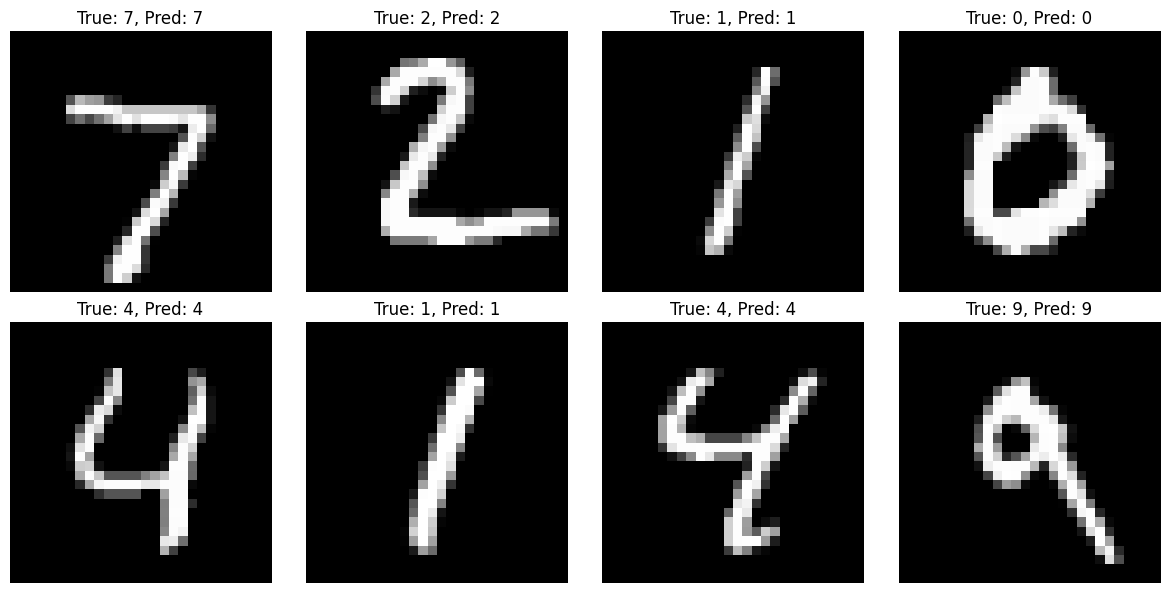

In [9]:
# Visualize some predictions
def visualize_predictions(model, test_loader, device, num_samples=8):
    model.eval()
    with torch.no_grad():
        # Get a batch of test data
        data_iter = iter(test_loader)
        images, labels = next(data_iter)
        images, labels = images.to(device), labels.to(device)
        
        # Get predictions
        outputs = model(images)
        _, predicted = outputs.max(1)
        
        # Move back to CPU for visualization
        images = images.cpu()
        labels = labels.cpu()
        predicted = predicted.cpu()
        
        # Create subplot
        fig, axes = plt.subplots(2, 4, figsize=(12, 6))
        axes = axes.ravel()
        
        for i in range(num_samples):
            axes[i].imshow(images[i].squeeze(), cmap='gray')
            axes[i].set_title(f'True: {labels[i].item()}, Pred: {predicted[i].item()}')
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()

# Visualize predictions
print("Visualizing some predictions...")
visualize_predictions(model, test_loader, device)


In [10]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST normalization
])

# Load training and test datasets
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Training samples: 60000
Test samples: 10000
